# Never gonna give you up
# Never gonna DRAG you down

Howdy folks. Today we'll be quantum mechanic.

In [3]:
# First we set up some basic dependencies

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

import qiskit as qis
import qiskit.pulse as qisp
from qiskit.circuit import Parameter, QuantumCircuit, Gate
from qiskit import IBMQ, schedule
from qiskit.providers.ibmq.managed import IBMQJobManager
from qiskit.compiler.assembler import MeasLevel, MeasReturnType
from qiskit.tools.monitor import job_monitor

if not IBMQ.active_account():
    IBMQ.load_account()
    
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibm_oslo')

In [4]:
qubit = 0
f01 = backend.configuration().hamiltonian['vars'][f'wq{qubit}']/(2*np.pi)
# drive_coupling = backend.configuration().hamiltonian['vars'][f'omegad{qubit}']

x_sigma = 80
x_duration = 320

x01_amp = 0.07513041041956571

In [5]:
scale_factor = 1e-7
def get_job_data(job, average):
    """Retrieve data from a job that has already run.
    Args:
        job (Job): The job whose data you want.
        average (bool): If True, gets the data assuming data is an average.
                        If False, gets the data assuming it is for single shots.
    Return:
        list: List containing job result data.
    """
    job_results = job.result()  # timeout parameter set to 120 s
    result_data = []
    for i in range(len(job_results.results)):
        if average:  # get avg data
            result_data.append(np.real(job_results.get_memory(i)[qubit] * scale_factor))
            print('here')
        else:  # get single data
            result_data.append(job_results.get_memory(i)[:, qubit] * scale_factor)
            print(i, end='\r')
    return result_data


def get_closest_multiple_of_16(num):
    """Compute the nearest multiple of 16. Needed because pulse enabled devices require
    durations which are multiples of 16 samples.
    """
    return int(num + 8) - (int(num + 8) % 16)

In [8]:
discriminator_job = backend.retrieve_job('6347db674a53e849a5e39285')

In [6]:
discriminator_data = get_job_data(discriminator_job, average=False)
zero_data = discriminator_data[0]
one_data = discriminator_data[1]
two_data = discriminator_data[2]


from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split

def reshape_complex_vec(vec):
    """Take in complex vector vec and return 2d array w/ real, imag entries. This is needed for the learning.
    Args:
        vec (list): complex vector of data
    Returns:
        list: vector w/ entries given by (real(vec], imag(vec))
    """
    length = len(vec)
    vec_reshaped = np.zeros((length, 2))
    for i in range(len(vec)):
        vec_reshaped[i] = [np.real(vec[i]), np.imag(vec[i])]
    return vec_reshaped


# Create IQ vector (split real, imag parts)
zero_data_reshaped = reshape_complex_vec(zero_data)
one_data_reshaped = reshape_complex_vec(one_data)
two_data_reshaped = reshape_complex_vec(two_data)

IQ_012_data = np.concatenate((zero_data_reshaped, one_data_reshaped, two_data_reshaped))
print(IQ_012_data.shape)  # verify IQ data shape

NUM_SHOTS = 20000

# construct vector w/ 0's, 1's and 2's (for testing)
state_012 = np.zeros(NUM_SHOTS)  # shots gives number of experiments
state_012 = np.concatenate((state_012, np.ones(NUM_SHOTS)))
state_012 = np.concatenate((state_012, 2 * np.ones(NUM_SHOTS)))
print(len(state_012))

# Shuffle and split data into training and test sets
IQ_012_train, IQ_012_test, state_012_train, state_012_test = train_test_split(IQ_012_data, state_012, test_size=0.5)

# Set up the LDA
LDA_012 = LinearDiscriminantAnalysis()
LDA_012.fit(IQ_012_train, state_012_train)


def count(job, discriminator):
    print('retrieving data from', job.job_id())
    data = get_job_data(job, average=False)
    print('data is retrieved from', job.job_id())
    sched_data = []
    for i in range(len(data)):
        sched_data.append(reshape_complex_vec(data[i]))
    discrim_data = []
    for j in range(len(sched_data)):
        discrim_data.append(discriminator.predict(sched_data[j]))
        print('predicting', j, end='\r')
    final_result = []
    for k in range(len(discrim_data)):
        result = {'0': 0, '1': 0, '2': 0}
        for l in range(len(discrim_data[k])):
            if discrim_data[k][l] == 0.0:
                result['0'] += 1
            elif discrim_data[k][l] == 1.0:
                result['1'] += 1
            elif discrim_data[k][l] == 2.0:
                result['2'] += 1
            else:
                print('Unexpected behavior')
        final_result.append(result)
    return final_result


NameError: name 'discriminator_job' is not defined

In [4]:
drive_betas = np.linspace(-25, 25, 100)
def exp_drag_circs(n, drive_betas):
    drive_beta = Parameter('drive_beta')
    with qisp.build(backend=backend, default_alignment='sequential') as XX_sched:
        qisp.set_frequency(f01, qisp.drive_channel(0))
        qisp.play(qisp.Drag(duration=x_duration,
                            amp=x01_amp,
                            sigma=x_sigma,
                            beta=drive_beta), qisp.drive_channel(0))
        qisp.shift_phase(-np.pi, qisp.drive_channel(0))
        qisp.play(qisp.Drag(duration=x_duration,
                            amp=x01_amp,
                            sigma=x_sigma,
                            beta=drive_beta), qisp.drive_channel(0))
        qisp.shift_phase(-np.pi, qisp.drive_channel(0))

    XX = Gate("$X_\pi X_{-\pi}$", 1, [drive_beta])
    qc_DRAG = QuantumCircuit(1, 1)
    qc_DRAG.x(0)
    i = 0
    while i < n:
        qc_DRAG.append(XX, [0])
        i += 1
    qc_DRAG.measure(0, 0)
    qc_DRAG.add_calibration(XX, (0,), XX_sched, [drive_beta])
    return [qc_DRAG.assign_parameters({drive_beta: b}, inplace=False) for b in drive_betas]

In [5]:
drag_job_single = []
drag_job_single_id = []
for i in range(5):
    drag_job = backend.run(exp_drag_circs(2*i + 3, drive_betas),
                           meas_level=1,
                           meas_return='single',
                           shots=20000)
    drag_job_single.append(drag_job)
    drag_job_single_id.append(drag_job.job_id())
drag_job_single_id

['6357f5ba1ff36453147496cc',
 '6357f5bd3bcead4fee5ea9ad',
 '6357f5c07a93ee2b5ee249cd',
 '6357f5c37a93ee2231e249cf',
 '6357f5c5333aebf44789eb9b']

# Oslo DRAG 12 calibration jobs
['6357f5ba1ff36453147496cc',
 '6357f5bd3bcead4fee5ea9ad',
 '6357f5c07a93ee2b5ee249cd',
 '6357f5c37a93ee2231e249cf',
 '6357f5c5333aebf44789eb9b']

In [1]:
def get_population(job_id, discriminator):
    drag_job = backend.retrieve_job(job_id)
    print('getting population from', job_id)
    drag_values = count(drag_job, discriminator)
    return [[val['0']/20000, val['1']/20000, val['2']/20000] for val in drag_values]

In [2]:
job_ids = ['6357f5ba1ff36453147496cc',
           '6357f5bd3bcead4fee5ea9ad',
           '6357f5c07a93ee2b5ee249cd',
           '6357f5c37a93ee2231e249cf',
           '6357f5c5333aebf44789eb9b']
colors = ['red', 'blue', 'green']
population = [get_population(id, LDA_012) for id in job_ids]

NameError: name 'LDA_012' is not defined

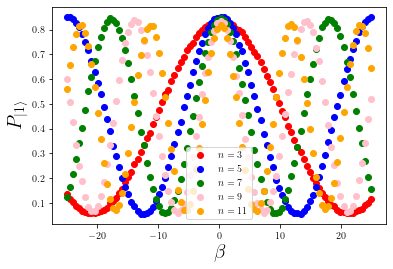

In [29]:
colors = ['red', 'blue', 'green', 'pink', 'orange']
plt.rcParams['text.usetex'] = True
for i in range(5):
    plt.scatter(drive_betas, [exp[1] for exp in population[i]], marker='o', linestyle='-', color= colors[i])
plt.legend([f'$n = {2*i + 3}$' for i in range(5)], fontsize = 10)
# plt.xlim(20, 40)
plt.xlabel('$\\beta$', fontsize = 20)
plt.ylabel('$P_{|1\\rangle}$', fontsize = 20)
plt.savefig('drag01_results.pdf')

In [24]:
from scipy.optimize import curve_fit


def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)

    return fitparams, y_fit


def sinusoid(x, A, B, drive_period, phi):
    return A * np.cos(2 * np.pi * x / drive_period - phi) + B

In [57]:
params = []
periods = [40, 20, 20, 20, 15]
for i in range(5):
    param = curve_fit(sinusoid, drive_betas, [exp[1] for exp in population[i]], [1, 0.5, periods[i], 0])[0]
    params.append(param)

In [35]:
params[0]

array([3.89106767e-01, 4.47547714e-01, 4.22326682e+01, 3.42307841e-02])

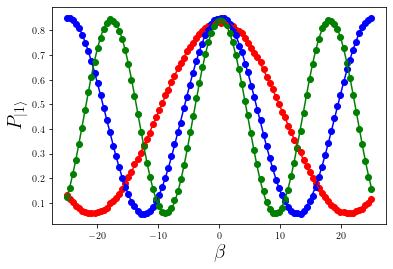

In [58]:
x_val = np.linspace(-25, 25, 1000)
for i in range(3):
    plt.scatter(drive_betas, [exp[1] for exp in population[i]], marker='o', linestyle='-', color= colors[i])
    plt.xlabel('$\\beta$', fontsize = 20)
    plt.ylabel('$P_{|1\\rangle}$', fontsize = 20)
    plt.plot(x_val, [sinusoid(x, *params[i]) for x in x_val], color=colors[i])
# plt.legend([f'$n = {2*i + 3}$' for i in range(5)], fontsize = 10)

drag job id oslo: 6347daa2e1fa1c3a61de3397

In [20]:
drag_job = backend.retrieve_job('6347daa2e1fa1c3a61de3397')

In [34]:
drag_results = drag_job.result(timeout=120)
drag_values = []
for i in range(99):
    drag_values.append(drag_results.get_memory(i)[qubit] * 1e-7)
iq_pts = drag_values
drag_values = np.real(drag_values)

0.1401401401401401

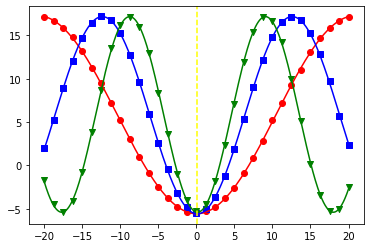

In [33]:
fit_params_n3, y_fit_n3 = fit_function(drive_betas,
                                       drag_values_n3,
                                       lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B),
                                       [10, 5, 40, 0])
fit_params_n5, y_fit_n5 = fit_function(drive_betas,
                                       drag_values_n5,
                                       lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B),
                                       [10, 5, 20, 0])
fit_params_n7, y_fit_n7 = fit_function(drive_betas,
                                       drag_values_n7,
                                       lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B),
                                       [10, 5, 20, 0])
x_val = np.linspace(-20, 20, 1000)
min_val = 1
beta_optimum = 0
for x in x_val:
    l = (sinusoid(x, fit_params_n3) + np.abs(fit_params_n3[0]) - fit_params_n3[1])**2 + (sinusoid(x, fit_params_n5) + np.abs(fit_params_n5[0]) - fit_params_n5[1])**2 + (sinusoid(x, fit_params_n7) + np.abs(fit_params_n7[0]) - fit_params_n7[1])**2
    if l < min_val:
        min_val = l
        x_optimum = x

plt.scatter(drive_betas, drag_values_n3, marker='o', linestyle='-', color='red')
plt.plot(x_val, sinusoid(x_val, fit_params_n3), color = 'red')
plt.scatter(drive_betas, drag_values_n5, marker='s', linestyle='-', color='blue')
plt.plot(x_val, sinusoid(x_val, fit_params_n5), color = 'blue')
plt.scatter(drive_betas, drag_values_n7, marker='v', linestyle='-', color='green')
plt.plot(x_val, sinusoid(x_val, fit_params_n7), color = 'green')
plt.axvline(x_optimum, linestyle='--', color='yellow')
# plt.xlim(-2, 2)
x_optimum

In [14]:
beta_optimum = x_optimum

In [15]:
with qisp.build(backend=backend, default_alignment='sequential') as SX_sched:
    qisp.set_frequency(drive_freq, qisp.drive_channel(0))
    qisp.play(qisp.Drag(duration=x_duration,
                        amp=x_amp/2,
                        sigma=x_sigma,
                        beta=beta_optimum), qisp.drive_channel(0))


In [13]:
SX_circs = []
for i in range(100):
    qc_SX = QuantumCircuit(1, 1)
    SX = Gate("$SX$", 1, [])
    qc_SX.add_calibration(SX, (0,), SX_sched, [])
    qc_SX.append(SX, [0])
    for j in range(i):
        qc_SX.append(SX, [0])
    qc_SX.measure(qubit, 0)
    SX_circs.append(qc_SX)

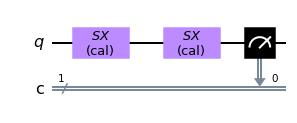

In [344]:
SX_circs[1].draw(output='mpl')

In [345]:
len(SX_circs)

100

In [346]:
SX_job = backend.run(SX_circs,
                    meas_level=2,
                    meas_return='single',
                    shots=2**14)
SX_job.job_id()

'633f8983e212b028d4beef0c'

In [117]:
job_monitor(SX_job)

Job Status: job is queued (156)

KeyboardInterrupt: 

# SX job
633ea125feb64c920ea00369: -1.3013013013013008
633f8983e212b028d4beef0c: -0.6206206206206204


In [59]:
SX_job = backend.retrieve_job('633f8983e212b028d4beef0c')

/home/khoinguyen/.local/lib/python3.10/site-packages/qiskit/providers/ibmq/ibmqbackend.py:691: UserWarning: Job 633f8983e212b028d4beef0c belongs to another backend than the one queried. The query was made on backend ibm_oslo, but the job actually belongs to backend ibmq_manila.
  warnings.warn('Job {} belongs to another backend than the one queried. '


IBMQBackendError: 'Failed to get job 633f8983e212b028d4beef0c: job does not belong to backend ibm_oslo.'

In [15]:
SX_results = SX_job.result().get_counts()

In [16]:
zero_population = [SX_results[i]['0']/2**14 for i in range(100)]
len(zero_population)

100

In [162]:
def SX_theory(val, epsilon):
    # return [1/2 + 1/2*np.cos(n*(np.pi/2 + epsilon)) for n in val]
    return [np.cos(n*(np.pi/2 + epsilon)/2)**2 for n in val]


[0.04397003]


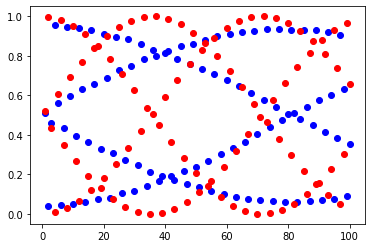

In [159]:
exp_num = [i + 1  for i in range(100)]

SX_params, SX_fit = fit_function(range(100),
                                       zero_population,
                                       SX_theory,
                                       [0.02])
print(SX_params)
plt.scatter(exp_num, zero_population, marker='o', linestyle='-', color='blue')
# plt.plot(range(100), SX_theory(range(100), SX_params), color='red')
# plt.xlim([0, 20])
plt.scatter(exp_num, SX_theory(exp_num, SX_params), color='red')

(0.0, 20.0)

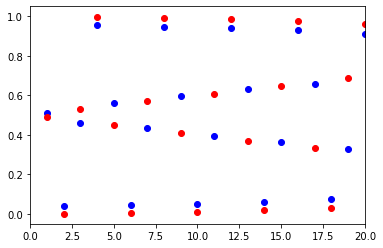

In [163]:
plt.scatter(exp_num, zero_population, marker='o', linestyle='-', color='blue')
plt.scatter(exp_num, SX_theory(exp_num, 0.02), color='red')
plt.xlim(0, 20)

In [18]:
SX_odd_circs = []
for i in range(100):
    qc_SX = QuantumCircuit(1, 1)
    SX = Gate("$SX$", 1, [])
    qc_SX.add_calibration(SX, (0,), SX_sched, [])
    qc_SX.append(SX, [0])
    for j in range(i):
        qc_SX.append(SX, [0])
        qc_SX.append(SX, [0])
    qc_SX.measure(qubit, 0)
    SX_odd_circs.append(qc_SX)


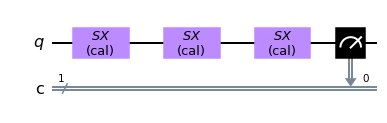

In [351]:
SX_odd_circs[1].draw(output='mpl')

In [266]:
SX_odd_job = backend.run(SX_odd_circs,
                     meas_level=2,
                     meas_return='single',
                     shots=2**14)
SX_odd_job.job_id()

'633ebe58338f42c077b76051'

In [19]:
SX_odd_job = backend.retrieve_job('633ebe58338f42c077b76051')

In [21]:
SX_odd_results = SX_odd_job.result().get_counts()
zero_population_odd = [SX_odd_results[i]['0']/2**14 for i in range(100)]

In [151]:
def SX_odd_theory(val, A, B, epsilon):
    # return [1/2 + 1/2*(-1)**n*np.cos(np.pi/2 + (2*n + 1)*epsilon) for n in val] #sheldon 2015
    return [A + B*np.cos((2*n + 1)*(epsilon + np.pi/2)) for n in val]
    # return [np.cos((epsilon + np.pi/2)*(n + 1/2))**2 for n in val]

In [169]:
num_fit = 78
exp_num = [i + 1  for i in range(100)]
SX_odd_params = curve_fit(SX_odd_theory, exp_num[:num_fit], zero_population_odd[:num_fit], p0 = [1/2, 1/2, 0.02], maxfev=5000)[0]
print(SX_odd_params)
residuals = [zero_population_odd[i] - SX_odd_theory(exp_num[i], *SX_odd_params) for i in range(num_fit)]
ss_res = np.sum(residuals**2)
ss_tot = np.sum((zero_population_odd[:num_fit]-np.mean(zero_population_odd[:num_fit]))**2)
r_squared = 1 - (ss_res / ss_tot)
print('r-squared =', r_squared)

plt.scatter(exp_num[:num_fit], zero_population_odd[:num_fit], marker='o', linestyle='-', color='blue')
# plt.plot(range(75), zero_population_odd[:75], marker='o', linestyle='-', color='blue')
# plt.xlim(0,10)

plt.scatter(exp_num[:num_fit], SX_odd_theory(range(num_fit), *SX_odd_params), color='red')

[0.50823087 0.4525394  0.02019534]


TypeError: 'int' object is not iterable

TypeError: SX_odd_theory() missing 2 required positional arguments: 'B' and 'epsilon'

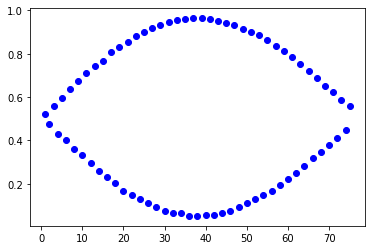

In [168]:
plt.scatter(exp_num[:75], zero_population_odd[:75], marker='o', linestyle='-', color='blue')
plt.scatter(exp_num[:75], SX_odd_theory(exp_num[:75], 0.02), color='red')
# plt.xlim(0, 10)